# 0. Initial setup, packages installation, and loading the necessary libraries.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
# PATH = '/content/drive/My Drive/Courses/FourthBrain/Week 8/Midterm Project/Option 1/'
PATH = ''
# os.chdir(PATH)

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from google.colab.patches import cv2_imshow
%matplotlib inline

from utils import *

In [4]:
# os.environ['CUDA_LAUNCH_BLOCKING']="1"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
from torchvision import models, transforms
import time
import copy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Building a Model to Classify Retinal Disease

 > ## 1.1 Exploratory Data Analysis

In [5]:
train_df = load_data(PATH+'data/train/train.csv', ',')
print(train_df.shape)

# Let's visualize some rows of the data. The first columns corresponds to the
# image file and the rest if the image contain any of the retinal disease.
train_df.head(100)

FILE EXIST
(3435, 8)


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
95,8518b692368f.jpg,1,1,0,1,0,0,0
96,7a3e5d2d09bc.jpg,1,1,0,1,0,0,0
97,b58ca12cea1b.jpg,1,0,0,0,0,0,0
98,698d188ddd7d.jpg,1,0,0,0,0,0,0


Let's visualize now some of the images corresponding to each retinal disease. This will help us to understand a bit better the problem at hand.

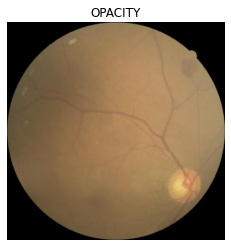

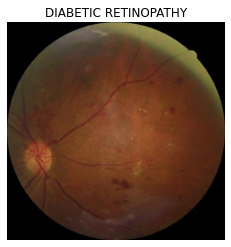

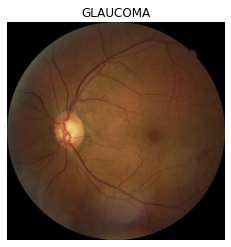

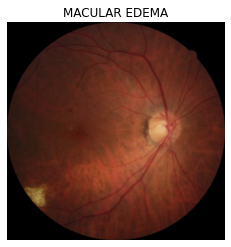

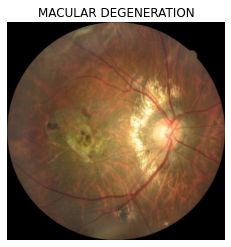

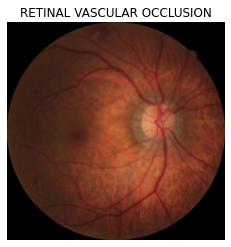

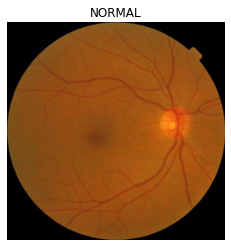

In [6]:
# Examples of retinal images correspinding to each category.
disease_labels = train_df.columns[1:]

for i in disease_labels:
    image_file = train_df.loc[train_df[i] == 1, 'filename'].sample().values[0]
    image = mpimg.imread(PATH+'data/train/train/'+image_file)
    
    plt.title(i.upper())
    plt.axis("off")
    plt.imshow(image)
    plt.show()

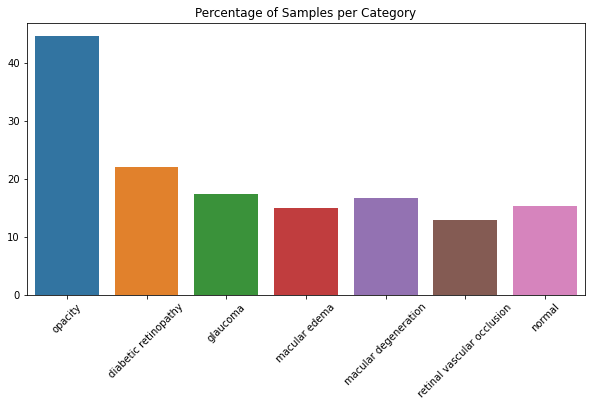

retinal vascular occlusion     440
macular edema                  516
normal                         525
macular degeneration           574
glaucoma                       597
diabetic retinopathy           755
opacity                       1533
dtype: int64


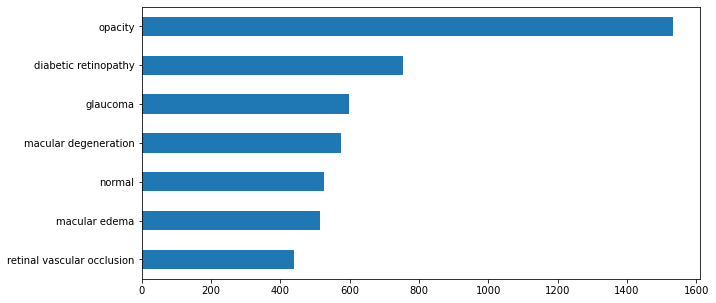

In [7]:
# Display the percentage and number of samples per disease label.
category_percentage(train_df, disease_labels)

plt.figure(figsize=(10, 5))
train_df[disease_labels].sum().sort_values().plot(kind='barh')
print(train_df[disease_labels].sum().sort_values())
plt.show()

After inspecting the previous graph it is evident that our data is imbalanced. There are for example 1000 (approx.) cases more of the label "*opacity*" compared to most of the other labels. 

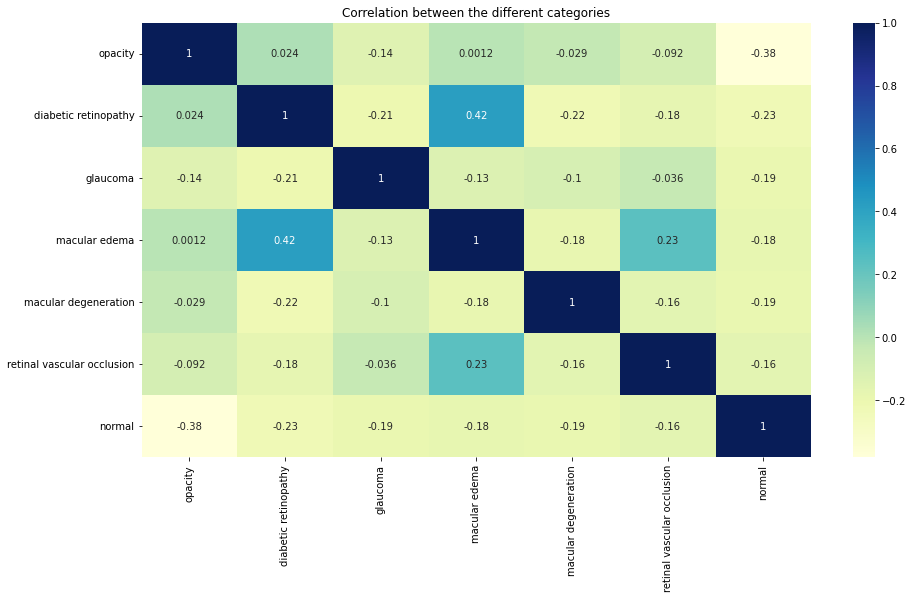

In [8]:
# Correlation between disease.
correlation_between_labels(train_df)

According to the correlation matrix, it seems there is no significant correlation between the different retinal disorders that are present in this dataset.

There is just a minor correlation  (`0.42`) between '*diabetic retinopathy*' and '*macular edema*', and (`0.23`) between '*macular edema*' and '*retinal vascular occlusion*'. Therefore, it shouln't be surprising that after training a model with this data, and when making predictions to an image with either '*diabetic retinopathy*' or '*macular edema*', then the image could get both labels.

A correlation is considered significant for values above `0.5` with a `p-value<0.05`.

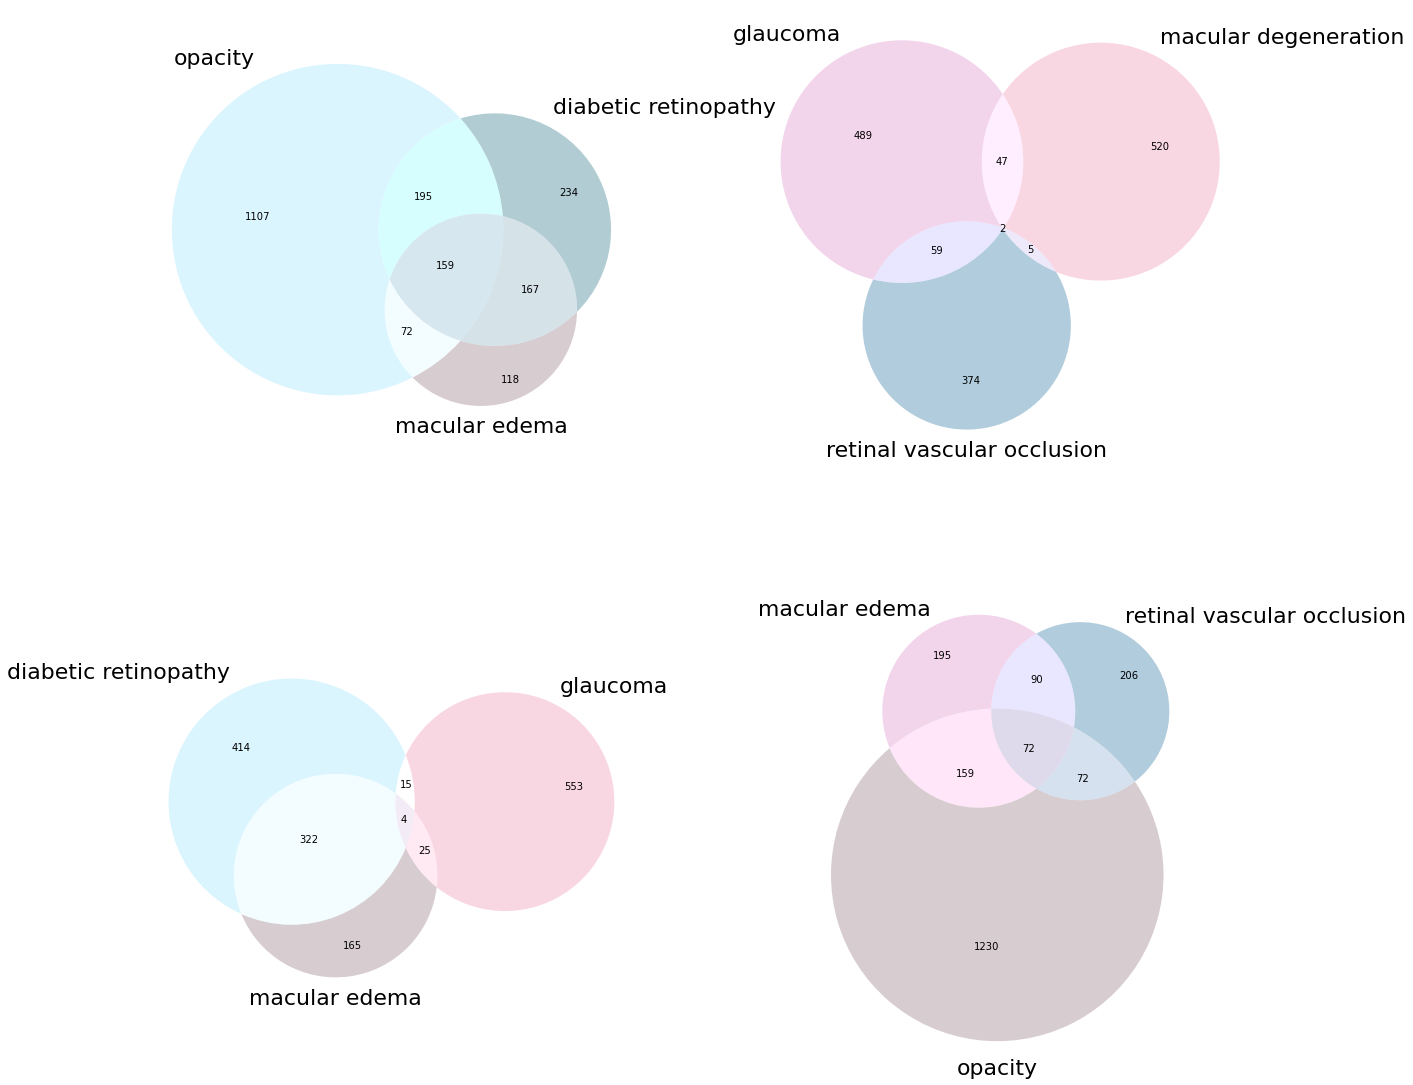

In [9]:
# Now let's explore the interrelation between categories.
venn_diagram(train_df, disease_labels, [0, 1, 3], [2, 4, 5], [1, 2, 3], [3, 5, 0])

As expected there is an overlap between the "macular edema" and the "diabetic retinopathy" disorder, and also some intersection of these two with '"opacity".

There is not much overlap between "glaucoma", "macular degeneration" and "retinal vascular occlusion".

There is also some overlap between "macular edema" and "retinal vascular oclusion".


 > ## 1.1.1 Filtering the clases in the dataset.

Filter the dataset to leave only the clases: "*diabetic retinopathy*", "*glaucoma*", and all the rest of disorders as "*other*". Category "*normal*" is kept.

In [10]:
train_dfv2 = train_df
train_dfv2['other'] = np.where(
        (train_dfv2['retinal vascular occlusion'] == 1) |
        (train_dfv2['macular edema'] == 1) |
        (train_dfv2['macular degeneration'] == 1) |
        (train_dfv2['opacity'] == 1), 1, 0)

train_dfv2 = train_df[['filename', 'diabetic retinopathy', 'glaucoma', 'other', 'normal']]

train_dfv2.head()

,filename,diabetic retinopathy,glaucoma,other,normal
0,c24a1b14d253.jpg,0,0,1,0
1,9ee905a41651.jpg,0,0,1,0
2,3f58d128caf6.jpg,0,1,0,0
3,4ce6599e7b20.jpg,0,0,1,0
4,0def470360e4.jpg,0,0,1,0


 > ## 1.2 Setting up of a data augmentation pipeline.

In the following cell I create a the dataset class containing a set of standard image transformations:


*   `transforms.Resize(224)`: for adjusting the image size to the networks' input
*   `transforms.RandomHorizontalFlip(p=1.0)`: flip the image on the horizontal edge
*   `transforms.RandomVerticalFlip(p=1.0)`: flip the image on the vertical edge
*   `transforms.Normalize()`: Normalize a tensor image with mean and standard deviation. The numbers are coming from the ImageNet dataset (This is because I will be using models pretrained on the ImageNet dataset).  




In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, data_file, img_dir, transform=None):
        self.img_data = data_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_data.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_data.iloc[[idx], 1:].values
        label = torch.tensor(label, dtype=torch.float32)
        image = self.transform(image)
        return image, torch.squeeze(label)

In [12]:
# Since the dataset is not that big, I decided to incorporate more images in the 
# training set. Therefore, I will be using 80% of the data for training, 15% for validation, and 5% for test.
train_df = train_dfv2
disease_labels = train_df.columns[1:]
train_data, validation_data = train_test_split(train_df, train_size=0.80, random_state=42, shuffle=True)
# Split validation into validation and test dataset
validation_data, test_data  = train_test_split(validation_data, train_size=0.75, random_state=42, shuffle=True)
print('Dataset Sizes:')
print(f'Train: {train_data.shape[0]}\nValidation: {validation_data.shape[0]}\nTest: {test_data.shape[0]}')

# Define the transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomVerticalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_df = {
    'train': train_data, 'val': validation_data, 'test': test_data
}

image_dataset = {x: CustomImageDataset(data_file=data_df[x],
                                       img_dir='data/train/train/',
                                       transform=data_transforms[x])
                 for x in ['train', 'val', 'test']}

batch_size = 32
dataloaders = {x: DataLoader(image_dataset[x], batch_size=batch_size,
                             shuffle=True, num_workers=0)
                for x in ['train', 'val', 'test']}

# Get some random training images
# images, labels = next(iter(dataloaders['train']))

# print('-'*30)
# print(images)
# print(type(images))
# print('-'*30)
# print(labels)
# print(type(labels))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Dataset Sizes:
Train: 2748
Validation: 515
Test: 172
cuda:0


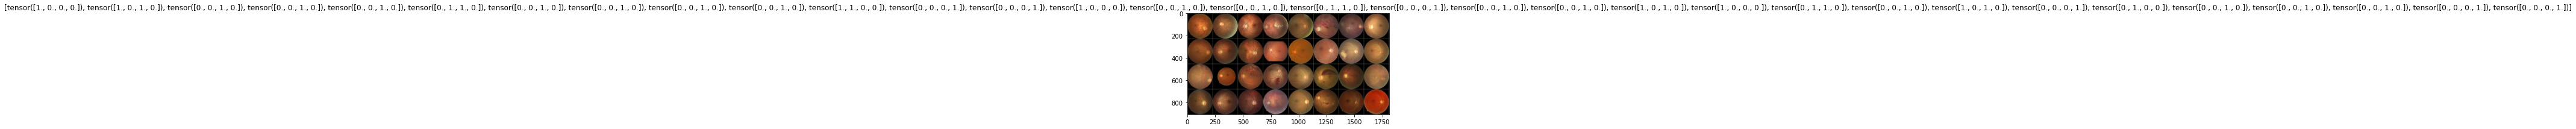

In [13]:
# Let's visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

In [14]:
# Training Function 
def train_model(model, criterion, optimizer, scheduler, model_name=None, weights=None, num_epochs=25):
    model_name = model_name if model_name else model.__class__.__name__
    since = time.time()
    # weights = weights.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    train_loss = []
    validation_loss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            run_Acc = 0.0
            run_Prec = 0.0
            run_Rec = 0.0
            run_F1 = 0.0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                              leave=True,
                                              total=int(len(image_dataset[phase])/dataloaders[phase].batch_size)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs)
                    preds = torch.round(preds)

                    loss = criterion(outputs, labels)
                    # loss = (loss * weights).mean()
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

                if phase == 'val':
                    y_true, y_pred = labels.data.detach().cpu(), preds.detach().cpu()

                    run_Acc += accuracy_score(y_true, y_pred)
                    run_Prec += precision_score(y_true, y_pred, average="samples", zero_division=0)
                    run_Rec += recall_score(y_true, y_pred, average="samples", zero_division=0)
                    run_F1 += f1_score(y_true, y_pred, average="samples", zero_division=0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(image_dataset[phase])

            if phase == 'train':
                # train_stats = '{} ==> Loss:{:.4f} Acc:{:.4f} Prec:{:.4f} Rec:{:.4f} F1:{:.4f}'.format(
                #     phase.upper(), epoch_loss, Acc_sc, Prec_sc, Rec_sc, f1_sc)
                train_stats = '{} ==> Loss:{:.4f}'.format(
                    phase.upper(), epoch_loss)
                train_loss.append(epoch_loss)
            else:
                Acc_sc = run_Acc / len(dataloaders[phase])
                Prec_sc = run_Prec / len(dataloaders[phase])
                Rec_sc = run_Rec / len(dataloaders[phase])
                f1_sc = run_F1 / len(dataloaders[phase])
                print(train_stats)
                print('{} ==> Loss:{:.4f} Acc:{:.4f} Prec:{:.4f} Rec:{:.4f} F1:{:.4f}'.format(
                    phase.upper(), epoch_loss, Acc_sc, Prec_sc, Rec_sc, f1_sc))
                validation_loss.append(epoch_loss)


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), PATH + 'models/'+model_name+'.pth')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, validation_loss

In [15]:
def print_loss_history(train_loss, validation_loss, logscale=False):
    loss = train_loss
    val_loss = validation_loss
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()
    return

I address the imbalance characteristics of the data by calculating a weight vector corresponding to the labels, to pass it to the loss function. (See [this example](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).)

In [16]:
def get_pos_weight(df):
  train_labels_df = df
  pos_weight = []
  for c in range(train_labels_df.shape[1]):
    weight = (train_labels_df.iloc[:, c] == 0).sum() / (train_labels_df.iloc[:, c] == 1).sum()
    pos_weight.append(weight)
  return pos_weight

In [17]:
def get_weights(df):
  train_labels_df = df
  weights = []
  for c in range(train_labels_df.shape[1]):
    weight = 1 / (train_labels_df.iloc[:, c] == 1).sum()
#     weight = len(train_labels_df) / (train_labels_df.iloc[:, c] == 1).sum()
    weights.append(weight)
  return weights

For this task I'll use transfer learning. Transfer learning is increasingly used due to the availability of many pretrained models on large datasets. Additionally, since often there is not much data, and the computational resources is limited, then it is better to use transfer learning and leverage on previous work.

I will be using a pretrained ResNet18 model on the ImageNet dataset. I will freeze almost half of the model and retrain only the last 4 layers. In image classification, the features "learned" by the first layers of a model correspond to basic image features, e.g., edges, lines, simple shapes, etc. Whereas the features learned by the last layers correspond to high level features, e.g., faces, objects, etc. Therefore, it makes sense to re-train only the last layers and freeze the rest. However, it is valid to point out that this is just one approach out of a few for transfer learning.

In [18]:
lr = 0.0001
epochs = 20
model_ft = models.resnet18(pretrained=True, progress=True)
# model_ft = models.resnet50(pretrained=True, progress=True)

# Let's freeze the layers from 1 to 6. Then we would train only the remaining layers.
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(p.numel() for p in model_ft.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(disease_labels))

model_ft = model_ft.to(device)


# weights = get_label_weights(data_df['train'].iloc[:, 1:])
# criterion = nn.BCEWithLogitsLoss(reduction='none')
pos_weight = get_pos_weight(data_df['train'].iloc[:, 1:])
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(pos_weight)


optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# model_ft, train_loss, validation_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                            weights=torch.tensor(pos_weight, dtype=torch.float32),
#                            num_epochs=epochs)

model_ft, train_loss, validation_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                                    model_name='ResNet18', weights=None,
                                                    num_epochs=epochs)

11,689,512 total number of parameters
11,006,440 parameters to train
tensor([3.7298, 4.6543, 0.4540, 5.4659], device='cuda:0')
Epoch 0/19
----------


86it [00:21,  3.95it/s]                        
17it [00:03,  5.15it/s]                        


TRAIN ==> Loss:0.5510
VAL ==> Loss:0.5233 Acc:0.5478 Prec:0.7325 Rec:0.8097 F1:0.7474


FileNotFoundError: [Errno 2] No such file or directory: 'models/ResNet18.pth'

In [ ]:
print_loss_history(train_loss, validation_loss)

#### Validation Statistics:

|Model        | Loss  | Accuracy  | Precision | Recall | F1     | 
|-------------|-------|-----------|-----------|--------|--------|
|**Resnet18** | 0.647 | 0.648     | 0.798     | 0.819  | 0.791  |  

In [ ]:
def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                actual_labels = [disease_labels[idx] for idx, value in enumerate(labels[j]) if value == 1]
                predicted_labels = [disease_labels[idx] for idx, value in enumerate(outputs[j]) if value == 1]
                ax.set_title(f'Actual: {actual_labels}\n Predicted: {predicted_labels}')
                imshow(inputs.cpu().data[j])
                plt.figure(figsize=(10, 10))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# print([disease_labels[idx] for idx, value in enumerate(test_array) if value == 1])

# Making some predictions on the test dataset:
visualize_model_predictions(model_ft, num_images=6)

The predictions of the model on the test dataset are very accurate, as evidence in the previous images.

In [ ]:
# Function to evaluate the model performance on the test dataset.
def test_model(model):
    model.eval()
    Acc, Prec, Rec, F1 = 0.0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for inputs, labels in iter(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            outputs = torch.round(outputs)
            
            y_true, y_pred = labels.detach().cpu(), outputs.detach().cpu()

            Acc += accuracy_score(y_true, y_pred)
            Prec += precision_score(y_true, y_pred, average="samples", zero_division=0)
            Rec += recall_score(y_true, y_pred, average="samples", zero_division=0)
            F1 += f1_score(y_true, y_pred, average="samples", zero_division=0)
        
        Acc = Acc / len(dataloaders['test'])
        Prec = Prec / len(dataloaders['test'])
        Rec = Rec / len(dataloaders['test'])
        F1 = F1 / len(dataloaders['test'])
        
    return Acc, Prec, Rec, F1

In [ ]:
Acc, Prec, Rec, F1 = test_model(model_ft)
print('Evaluation on the test dataset:')
print('Accuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}'.format(
    Acc, Prec, Rec, F1))

#### Statistics on the test dataset:

|Model        | Accuracy  | Precision | Recall | F1     | 
|-------------|-----------|-----------|--------|--------|
|**Resnet18** | 0.583     | 0.775     | 0.795  | 0.763  | 

Next, I'll test if training a ResNet50 model would yield better results.

In [ ]:
torch.cuda.empty_cache()
model_ft2 = models.resnet50(pretrained=True, progress=True)

# Let's freeze the layers from 1 to 6. Then we would train only the remaining layers.
ct = 0
for child in model_ft2.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(p.numel() for p in model_ft2.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model_ft2.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

num_ftrs = model_ft2.fc.in_features
model_ft2.fc = nn.Linear(num_ftrs, len(disease_labels))

model_ft2 = model_ft2.to(device)

pos_weight = get_pos_weight(data_df['train'].iloc[:, 1:])
pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print(pos_weight)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft2.parameters()), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft2, train_loss, validation_loss = train_model(model_ft2, criterion, optimizer_ft, exp_lr_scheduler,
                                                    model_name='ResNet50', weights=None,
                                                    num_epochs=epochs)

In [ ]:
print_loss_history(train_loss, validation_loss)

#### Validation Statistics:

|Model        | Loss  | Accuracy  | Precision | Recall | F1     | 
|-------------|-------|-----------|-----------|--------|--------|
|**Resnet50** | 0.487 | 0.700     | 0.830     | 0.864  | 0.831  |  

In [ ]:
# Making some predictions on the test dataset:
visualize_model_predictions(model_ft2, num_images=6)

The predictions of the model on the test dataset are very accurate, as evidence in the previous images.

In [ ]:
Acc, Prec, Rec, F1 = test_model(model_ft2)
print('Evaluation on the test dataset:')
print('Accuracy:{:.3f}\nPrecision:{:.3f}\nRecall:{:.3f}\nF1:{:.3f}'.format(
    Acc, Prec, Rec, F1))

#### Statistics on the test dataset:

|Model        | Accuracy  | Precision | Recall | F1     | 
|-------------|-----------|-----------|--------|--------|
|**Resnet18** | 0.583     | 0.775     | 0.795  | 0.763  |
|**Resnet50** | 0.679     | 0.834     | 0.850  | 0.826  |

#### According to the statistics the **Resnet50** model performs better.

# 2. Visualizing regions of interest that contribute to the prediction of retinal disorders.

For this task I hand-picked a few images from the test dataset to showcase different retinal disorders. I base my approcah on [this work](https://github.com/jacobgil/pytorch-grad-cam).

In [ ]:
# Load the best performing model (Resnet50)
model_ft2 = models.resnet50()
num_ftrs = model_ft2.fc.in_features
model_ft2.fc = nn.Linear(num_ftrs, len(disease_labels))
model_ft2.load_state_dict(torch.load('models/ResNet50.pth'))

In [ ]:
from PIL import Image
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.shape[0] + im2.shape[0], im1.shape[1]))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.shape[0], 0))
    return dst

In [ ]:
model = model_ft2
target_layers = [model.layer4[-1]]

# Examples images from the test dataset. These where selected manually to showcase different retinal disrders.
example_images = (('data/train/train/30c12f1232bb.jpg', [0, 1, 0, 0]),
                ('data/train/train/0054be0a30b1.jpg', [1, 0, 1, 0]),
                ('data/train/train/50af8887791e.jpg', [0, 1, 0, 0]),
                ('data/train/train/ef8933d65998.jpg', [1, 0, 0, 0]),
                ('data/train/train/4b6f2e8f0a3d.jpg', [0, 0, 0, 1]))

for img_path, label in example_images:
    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    target_category = None
    with GradCAM(model=model,
                 target_layers=target_layers,
                 use_cuda=True) as cam:

        cam.batch_size = 32

        grayscale_cam = cam(input_tensor=input_tensor,
                            target_category=target_category,
                            aug_smooth=True,
                            eigen_smooth=True)

        # Here grayscale_cam has only one image in the batch
        grayscale_cam = grayscale_cam[0, :]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
        cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, target_category=target_category)

    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = deprocess_image(cam_mask * gb)
    gb = deprocess_image(gb)

    method = 'GradCAM'
    # cv2.imwrite(f'{method}_cam.jpg', cam_image)
    # cv2.imwrite(f'{method}_gb.jpg', gb)
    # cv2.imwrite(f'{method}_cam_gb.jpg', cam_gb)

    visualization = show_cam_on_image(rgb_img, grayscale_cam)

    ims = np.concatenate((rgb_img,
                          np.float32(visualization)/255,
                          np.float32(gb)/255
                         ), axis=1)

    labels = [disease_labels[idx] for idx, value in enumerate(label) if value == 1]

    plt.title(labels)
    plt.axis("off")
    plt.imshow(ims)
    plt.show()

The images above show the regions of "interest" that cause the model to make a particular prediction. Areas colored in red being important and blue less important. It can be seen in the first image that for that particular case of glaucoma, the model focused on some edges of the retina and on a spot near the center to the left. On the other hand the last three images the focus of the network is not as evident like the first images, but a close look revelas light yellow areas which is where the model focused in these cases to make a prediction. 